In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

from tqdm import tqdm_notebook as tqdm
import os
import time
import json
import collections
import gc

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import lightgbm as lgb

In [2]:
data_dir = '/kaggle/input/mlcourse-dota2-win-prediction/'

# JSON

In [3]:
def read_matches(matches_file):
    MATCHES_COUNT = {
        'test_matches.jsonl': 10000,
        'train_matches.jsonl': 39675,
    }
    _, filename = os.path.split(matches_file)
    total_matches = MATCHES_COUNT.get(filename)

    with open(matches_file) as fin:
        for line in tqdm(fin, total=total_matches):
            yield json.loads(line)

def get_tdata(player, col):
    tdata = [player[col][i] for i in range(len(player['times'])) if player['times'][i] % 300 == 0][1:4]
    tdata += [0] * (3 - len(tdata))
    return tdata

def get_linear_coef(xt, yt):
    if len(yt) > 1:
        a, _, _, _ = np.linalg.lstsq(xt.reshape(-1, 1), yt.reshape(-1, 1))
        return a[0][0]
    return 0

def get_linear_coefs(xt, yt):
    if len(yt) > 1:
        coefs = np.polyfit(xt, yt, 1)
        return coefs
    return [0, 0]

def get_dynamic(players):
    time_dynamic = {team: {'times': list(), 'gold_t': list(), 'xp_t': list()} for team in ['r', 'd', 'diff']}
    for slot, player in enumerate(players):
        if slot < 5:
            time_dynamic['r']['times'].append(player['times'])
            time_dynamic['r']['gold_t'].append(player['gold_t'])
            time_dynamic['r']['xp_t'].append(player['xp_t'])
        else:
            time_dynamic['d']['times'].append(player['times'])
            time_dynamic['d']['gold_t'].append(player['gold_t'])
            time_dynamic['d']['xp_t'].append(player['xp_t'])
    
    for team in ['r', 'd']:
        for col in ['times', 'gold_t', 'xp_t']:
            time_dynamic[team][col] = np.mean(time_dynamic[team][col], axis=0)
    time_dynamic['diff']['times'] = time_dynamic['r']['times']
    time_dynamic['diff']['gold_t'] = time_dynamic['r']['gold_t'] - time_dynamic['d']['gold_t']
    time_dynamic['diff']['xp_t'] = time_dynamic['r']['xp_t'] - time_dynamic['d']['xp_t']
    
    lin_coefs = dict()
    for team in ['r', 'd', 'diff']:
        for col in ['gold_t', 'xp_t']:
            lin_coefs[f'{team}_{col}'] = get_linear_coef(time_dynamic[team]['times'], time_dynamic[team][col])
            for n_dots in [5, 10, 15]:
                coefs = get_linear_coefs(time_dynamic[team]['times'][:n_dots], time_dynamic[team][col][:n_dots])
                lin_coefs[f'{team}_{col}_{n_dots}_0'] = coefs[0]
                lin_coefs[f'{team}_{col}_{n_dots}_1'] = coefs[1]
            for n_dots in [-5, -10, -15]:
                coefs = get_linear_coefs(time_dynamic[team]['times'][n_dots:], time_dynamic[team][col][n_dots:])
                lin_coefs[f'{team}_{col}_{n_dots}_0'] = coefs[0]
                lin_coefs[f'{team}_{col}_{n_dots}_1'] = coefs[1]
    return lin_coefs

def extract_features_csv(match):
    if match['players'][0]['times']:
        max_ptime = match['players'][0]['times'][-1]
    else:
        max_ptime = 60
    
    row = [
        ('match_id_hash', match['match_id_hash']),
        ('game_time', max(max_ptime, match['game_time'])),
    ]
    
    bar = np.zeros(12)
    for obj in match['objectives']:
        if obj['type'] == 'CHAT_MESSAGE_BARRACKS_KILL':
            idx = int(np.log2(int(obj['key'])))
            bar[idx] = 1  # match['game_time'] - obj['time']
    for n_bar, killed in enumerate(bar):
        row.append((f'barrack_{n_bar}', killed))
    row.append((f'barracks_dire', bar[:6].sum()))
    row.append((f'barracks_rad', bar[6:].sum()))
    row.append((f'barracks_diff', bar[:6].sum() - bar[6:].sum()))

    rosh_kill = {'time': 0, 'team': 0}
    for obj in match['objectives'][::-1]:
        if obj['type'] == 'CHAT_MESSAGE_ROSHAN_KILL':
            rosh_kill['time'] = obj['time']
            rosh_kill['team'] = 1 if obj['team'] == 2 else -1
            break
    row.append((f'roshan_kill_time', rosh_kill['time']))
    row.append((f'roshan_kill_team', rosh_kill['team']))        

    lin_coefs = get_dynamic(match['players'])
    for coef_name, coef in lin_coefs.items():
        row.append((coef_name, coef))
            
    for slot, player in enumerate(match['players']):
        if slot < 5:
            player_name = 'r%d' % (slot + 1)
        else:
            player_name = 'd%d' % (slot - 4)
            
        row.append((f'{player_name}_gold_for_check', player['gold']))
        row.append((f'{player_name}_ability_level', len(player['ability_upgrades'])))
        row.append((f'{player_name}_max_hero_hit', player['max_hero_hit']['value']))
        row.append((f'{player_name}_purchase_count', len(player['purchase_log'])))
        row.append((f'{player_name}_count_ability_use', sum(player['ability_uses'].values())))
        row.append((f'{player_name}_damage_dealt', sum(player['damage'].values())))
        row.append((f'{player_name}_damage_received', sum(player['damage_taken'].values())))

        row.append((f'{player_name}_killed', sum(player['killed'].values())))
        row.append((f'{player_name}_hkilled',
                    np.sum([v for k, v in player['killed'].items() if k.startswith('npc_dota_hero')])))
        row.append((f'{player_name}_item_uses', sum(player['item_uses'].values())))
        row.append((f'{player_name}_damage_dealt_heroes',
                    np.sum([v for k, v in player['damage'].items() if k.startswith('npc_dota_hero')])))
        row.append((f'{player_name}_damage_received_heroes',
                    np.sum([v for k, v in player['damage_taken'].items() if k.startswith('npc_dota_hero')])))
        row.append((f'{player_name}_hero_inventory', ' '.join([item['id'] for item in player['hero_inventory']])))
        row.append((f'{player_name}_hero_stash', ' '.join([item['id'] for item in player['hero_stash']])))

        for col in ['gold_t', 'xp_t']:
            for n_ten, val in enumerate(get_tdata(player, col)):
                row.append((f'{player_name}_{col}{(n_ten + 1) * 5}m', val))

        time_bb = 0
        if player['buyback_log']:
            time_bb = match['game_time'] - player['buyback_log'][-1]['time']
        row.append((f'{player_name}_buyback_time', time_bb))
        row.append((f'{player_name}_buyback_count', len(player['buyback_log'])))

        player_params = dict()
        for col, col_size in [('actions', 37), ('gold_reasons', 16), ('xp_reasons', 4), ('life_state', 3)]:
            player_params[col] = np.zeros(col_size)
            for idx, val in player[col].items():
                player_params[col][int(idx)] = val

        for col, col_size in [('hero_inventory', 6), ('hero_stash', 6)]:
            player_params[col] = [''] * col_size
            for idx, item in enumerate(player[col]):
                player_params[col][idx] = item['id']

        for col in player_params.keys():
            for idx, val in enumerate(player_params[col]):
                row.append((f'{player_name}_{col}_{idx}', val))

    return collections.OrderedDict(row)

In [4]:
try:
    del train_new_features, test_new_features
    gc.collect()
except:
    pass

train_new_features = []
test_new_features = []

for match in read_matches(os.path.join(data_dir, 'train_matches.jsonl')):
    features = extract_features_csv(match)
    train_new_features.append(features)

for match in read_matches(os.path.join(data_dir, 'test_matches.jsonl')):
    features = extract_features_csv(match)
    test_new_features.append(features)

train_new_features = pd.DataFrame.from_records(train_new_features).set_index('match_id_hash')
test_new_features = pd.DataFrame.from_records(test_new_features).set_index('match_id_hash')

In [5]:
col_mask = np.zeros(train_new_features.shape[-1], dtype=np.bool)
for i, col in enumerate(train_new_features.columns):
    if train_new_features[col].dtype != 'object':
        col_mask[i] = train_new_features[col].apply(np.abs).sum() > 0
    else:
        col_mask[i] = train_new_features[col].apply(len).sum() > 0
train_new_features = train_new_features.loc[:, col_mask]
test_new_features = test_new_features.loc[:, col_mask]

In [6]:
train_new_features.head()

,game_time,barrack_0,barrack_1,barrack_2,barrack_3,barrack_4,barrack_5,barrack_6,barrack_7,barrack_8,barrack_9,barrack_10,barrack_11,barracks_dire,barracks_rad,barracks_diff,roshan_kill_time,roshan_kill_team,r_gold_t,r_gold_t_5_0,r_gold_t_5_1,r_gold_t_10_0,r_gold_t_10_1,r_gold_t_15_0,r_gold_t_15_1,r_gold_t_-5_0,r_gold_t_-5_1,r_gold_t_-10_0,r_gold_t_-10_1,r_gold_t_-15_0,r_gold_t_-15_1,r_xp_t,r_xp_t_5_0,r_xp_t_5_1,r_xp_t_10_0,r_xp_t_10_1,r_xp_t_15_0,r_xp_t_15_1,r_xp_t_-5_0,r_xp_t_-5_1,r_xp_t_-10_0,r_xp_t_-10_1,r_xp_t_-15_0,r_xp_t_-15_1,d_gold_t,d_gold_t_5_0,d_gold_t_5_1,d_gold_t_10_0,d_gold_t_10_1,d_gold_t_15_0,d_gold_t_15_1,d_gold_t_-5_0,d_gold_t_-5_1,d_gold_t_-10_0,d_gold_t_-10_1,d_gold_t_-15_0,d_gold_t_-15_1,d_xp_t,d_xp_t_5_0,d_xp_t_5_1,d_xp_t_10_0,d_xp_t_10_1,d_xp_t_15_0,d_xp_t_15_1,d_xp_t_-5_0,d_xp_t_-5_1,d_xp_t_-10_0,d_xp_t_-10_1,d_xp_t_-15_0,d_xp_t_-15_1,diff_gold_t,diff_gold_t_5_0,diff_gold_t_5_1,diff_gold_t_10_0,diff_gold_t_10_1,diff_gold_t_15_0,diff_gold_t_15_1,diff_gold_t_-5_0,diff_gold_t_-5_1,diff_gold_t_-10_0,diff_gold_t_-10_1,diff_gold_t_-15_0,diff_gold_t_-15_1,diff_xp_t,diff_xp_t_5_0,diff_xp_t_5_1,diff_xp_t_10_0,diff_xp_t_10_1,diff_xp_t_15_0,diff_xp_t_15_1,diff_xp_t_-5_0,diff_xp_t_-5_1,diff_xp_t_-10_0,diff_xp_t_-10_1,diff_xp_t_-15_0,diff_xp_t_-15_1,r1_gold_for_check,r1_ability_level,r1_max_hero_hit,r1_purchase_count,r1_count_ability_use,r1_damage_dealt,r1_damage_received,r1_killed,r1_hkilled,r1_item_uses,r1_damage_dealt_heroes,r1_damage_received_heroes,r1_hero_inventory,r1_hero_stash,r1_gold_t5m,r1_gold_t10m,r1_gold_t15m,r1_xp_t5m,r1_xp_t10m,r1_xp_t15m,r1_buyback_time,r1_buyback_count,r1_actions_0,r1_actions_1,r1_actions_2,r1_actions_3,r1_actions_4,r1_actions_5,r1_actions_6,r1_actions_7,r1_actions_8,r1_actions_9,r1_actions_10,r1_actions_11,r1_actions_12,r1_actions_13,r1_actions_14,r1_actions_15,r1_actions_16,r1_actions_17,r1_actions_18,r1_actions_19,r1_actions_20,r1_actions_21,r1_actions_23,r1_actions_24,r1_actions_25,r1_actions_27,r1_actions_28,r1_actions_29,r1_actions_30,r1_actions_31,r1_actions_32,r1_actions_33,r1_actions_36,r1_gold_reasons_0,r1_gold_reasons_1,r1_gold_reasons_2,r1_gold_reasons_5,r1_gold_reasons_6,r1_gold_reasons_11,r1_gold_reasons_12,r1_gold_reasons_13,r1_gold_reasons_14,r1_gold_reasons_15,r1_xp_reasons_0,r1_xp_reasons_1,r1_xp_reasons_2,r1_xp_reasons_3,r1_life_state_0,r1_life_state_1,r1_life_state_2,r1_hero_inventory_0,r1_hero_inventory_1,r1_hero_inventory_2,r1_hero_inventory_3,r1_hero_inventory_4,r1_hero_inventory_5,r1_hero_stash_0,r1_hero_stash_1,r1_hero_stash_2,r1_hero_stash_3,r1_hero_stash_4,r1_hero_stash_5,r2_gold_for_check,r2_ability_level,r2_max_hero_hit,r2_purchase_count,r2_count_ability_use,r2_damage_dealt,r2_damage_received,r2_killed,r2_hkilled,r2_item_uses,r2_damage_dealt_heroes,r2_damage_received_heroes,r2_hero_inventory,r2_hero_stash,r2_gold_t5m,r2_gold_t10m,r2_gold_t15m,r2_xp_t5m,r2_xp_t10m,r2_xp_t15m,r2_buyback_time,r2_buyback_count,r2_actions_1,r2_actions_2,r2_actions_3,r2_actions_4,r2_actions_5,r2_actions_6,r2_actions_7,r2_actions_8,r2_actions_9,r2_actions_10,r2_actions_11,r2_actions_12,r2_actions_13,r2_actions_14,r2_actions_15,r2_actions_16,r2_actions_17,r2_actions_18,r2_actions_19,r2_actions_20,r2_actions_21,r2_actions_23,r2_actions_24,r2_actions_25,r2_actions_26,r2_actions_27,r2_actions_28,r2_actions_29,r2_actions_30,r2_actions_31,r2_actions_32,r2_actions_33,r2_actions_36,r2_gold_reasons_0,r2_gold_reasons_1,r2_gold_reasons_2,r2_gold_reasons_5,r2_gold_reasons_6,r2_gold_reasons_11,r2_gold_reasons_12,r2_gold_reasons_13,r2_gold_reasons_14,r2_gold_reasons_15,r2_xp_reasons_0,r2_xp_reasons_1,r2_xp_reasons_2,r2_xp_reasons_3,r2_life_state_0,r2_life_state_1,r2_life_state_2,r2_hero_inventory_0,r2_hero_inventory_1,r2_hero_inventory_2,r2_hero_inventory_3,r2_hero_inventory_4,r2_hero_inventory_5,r2_hero_stash_0,r2_hero_stash_1,r2_hero_stash_2,r2_hero_stash_3,r2_hero_stash_4,r2_hero_stash_5,r3_gold_for_check,r3_ability_level,r3_max_hero_hit,r3_purchase_count,r3_count_ability_use,r3_damage_d

In [7]:
cols_as_is = ['barracks_dire', 'barracks_rad', 'barracks_diff', 'game_time', 'roshan_kill_time', 'roshan_kill_team'] + \
                [col for col in train_new_features.columns if ('_gold_t_' in col) or ('_xp_t_' in col)]
cols_to_sum = ['purchase_count', 'damage_dealt', 'damage_received', 'gold_t5m', 'gold_t10m', 'gold_t15m'] + \
                [col[3:] for col in train_new_features.columns if ('r1_gold_reasons_' in col) or ('r1_actions_' in col) or ('r1_life_state_' in col)]
inv_col = 'hero_inventory'

team_train = train_new_features[cols_as_is]
team_test = test_new_features[cols_as_is]

for df, df_team in [(train_new_features, team_train), (test_new_features, team_test)]:
    for team in ['r', 'd']:
        for col in cols_to_sum:
            team_col_name = team + '_' + col
            players_cols = [f"{team}{i}_{col}" for i in range(1, 6) if f"{team}{i}_{col}" in df.columns]
            df_team[team_col_name + '_sum'] = df[players_cols].sum(axis=1)

        inv_cols = [f"{team}{i}_{inv_col}" for i in range(1, 6)]
        df_team[f"{team}_{inv_col}"] = df[inv_cols].apply(lambda row: ' '.join(row), axis=1) 
        
    for col in cols_to_sum:
        team_col_name = 'sub_' + col
        df_team[team_col_name + '_sum'] = df_team[f"r_{col}_sum"] - df_team[f"d_{col}_sum"]
        
team_train.tail(5)

,barracks_dire,barracks_rad,barracks_diff,game_time,roshan_kill_time,roshan_kill_team,r_gold_t_5_0,r_gold_t_5_1,r_gold_t_10_0,r_gold_t_10_1,r_gold_t_15_0,r_gold_t_15_1,r_gold_t_-5_0,r_gold_t_-5_1,r_gold_t_-10_0,r_gold_t_-10_1,r_gold_t_-15_0,r_gold_t_-15_1,r_xp_t_5_0,r_xp_t_5_1,r_xp_t_10_0,r_xp_t_10_1,r_xp_t_15_0,r_xp_t_15_1,r_xp_t_-5_0,r_xp_t_-5_1,r_xp_t_-10_0,r_xp_t_-10_1,r_xp_t_-15_0,r_xp_t_-15_1,d_gold_t_5_0,d_gold_t_5_1,d_gold_t_10_0,d_gold_t_10_1,d_gold_t_15_0,d_gold_t_15_1,d_gold_t_-5_0,d_gold_t_-5_1,d_gold_t_-10_0,d_gold_t_-10_1,d_gold_t_-15_0,d_gold_t_-15_1,d_xp_t_5_0,d_xp_t_5_1,d_xp_t_10_0,d_xp_t_10_1,d_xp_t_15_0,d_xp_t_15_1,d_xp_t_-5_0,d_xp_t_-5_1,d_xp_t_-10_0,d_xp_t_-10_1,d_xp_t_-15_0,d_xp_t_-15_1,diff_gold_t_5_0,diff_gold_t_5_1,diff_gold_t_10_0,diff_gold_t_10_1,diff_gold_t_15_0,diff_gold_t_15_1,diff_gold_t_-5_0,diff_gold_t_-5_1,diff_gold_t_-10_0,diff_gold_t_-10_1,diff_gold_t_-15_0,diff_gold_t_-15_1,diff_xp_t_5_0,diff_xp_t_5_1,diff_xp_t_10_0,diff_xp_t_10_1,diff_xp_t_15_0,diff_xp_t_15_1,diff_xp_t_-5_0,diff_xp_t_-5_1,diff_xp_t_-10_0,diff_xp_t_-10_1,diff_xp_t_-15_0,diff_xp_t_-15_1,r_purchase_count_sum,r_damage_dealt_sum,r_damage_received_sum,r_gold_t5m_sum,r_gold_t10m_sum,r_gold_t15m_sum,r_actions_0_sum,r_actions_1_sum,r_actions_2_sum,r_actions_3_sum,r_actions_4_sum,r_actions_5_sum,r_actions_6_sum,r_actions_7_sum,r_actions_8_sum,r_actions_9_sum,r_actions_10_sum,r_actions_11_sum,r_actions_12_sum,r_actions_13_sum,r_actions_14_sum,r_actions_15_sum,r_actions_16_sum,r_actions_17_sum,r_actions_18_sum,r_actions_19_sum,r_actions_20_sum,r_actions_21_sum,r_actions_23_sum,r_actions_24_sum,r_actions_25_sum,r_actions_27_sum,r_actions_28_sum,r_actions_29_sum,r_actions_30_sum,r_actions_31_sum,r_actions_32_sum,r_actions_33_sum,r_actions_36_sum,r_gold_reasons_0_sum,r_gold_reasons_1_sum,r_gold_reasons_2_sum,r_gold_reasons_5_sum,r_gold_reasons_6_sum,r_gold_reasons_11_sum,r_gold_reasons_12_sum,r_gold_reasons_13_sum,r_gold_reasons_14_sum,r_gold_reasons_15_sum,r_life_state_0_sum,r_life_state_1_sum,r_life_state_2_sum,r_hero_inventory,d_purchase_count_sum,d_damage_dealt_sum,d_damage_received_sum,d_gold_t5m_sum,d_gold_t10m_sum,d_gold_t15m_sum,d_actions_0_sum,d_actions_1_sum,d_actions_2_sum,d_actions_3_sum,d_actions_4_sum,d_actions_5_sum,d_actions_6_sum,d_actions_7_sum,d_actions_8_sum,d_actions_9_sum,d_actions_10_sum,d_actions_11_sum,d_actions_12_sum,d_actions_13_sum,d_actions_14_sum,d_actions_15_sum,d_actions_16_sum,d_actions_17_sum,d_actions_18_sum,d_actions_19_sum,d_actions_20_sum,d_actions_21_sum,d_actions_23_sum,d_actions_24_sum,d_actions_25_sum,d_actions_27_sum,d_actions_28_sum,d_actions_29_sum,d_actions_30_sum,d_actions_31_sum,d_actions_32_sum,d_actions_33_sum,d_actions_36_sum,d_gold_reasons_0_sum,d_gold_reasons_1_sum,d_gold_reasons_2_sum,d_gold_reasons_5_sum,d_gold_reasons_6_sum,d_gold_reasons_11_sum,d_gold_reasons_12_sum,d_gold_reasons_13_sum,d_gold_reasons_14_sum,d_gold_reasons_15_sum,d_life_state_0_sum,d_life_state_1_sum,d_life_state_2_sum,d_hero_inventory,sub_purchase_count_sum,sub_damage_dealt_sum,sub_damage_received_sum,sub_gold_t5m_sum,sub_gold_t10m_sum,sub_gold_t15m_sum,sub_actions_0_sum,sub_actions_1_sum,sub_actions_2_sum,sub_actions_3_sum,sub_actions_4_sum,sub_actions_5_sum,sub_actions_6_sum,sub_actions_7_sum,sub_actions_8_sum,sub_actions_9_sum,sub_actions_10_sum,sub_actions_11_sum,sub_actions_12_sum,sub_actions_13_sum,sub_actions_14_sum,sub_actions_15_sum,sub_actions_16_sum,sub_actions_17_sum,sub_actions_18_sum,sub_actions_19_sum,sub_actions_20_sum,sub_actions_21_sum,sub_actions_23_sum,sub_actions_24_sum,sub_actions_25_sum,sub_actions_27_sum,sub_actions_28_sum,sub_actions_29_sum,sub_actions_30_sum,sub_actions_31_sum,sub_actions_32_sum,sub_actions_33_sum,sub_actions_36_sum,sub_gold_reasons_0_sum,sub_gold_reasons_1_sum,sub_gold_reasons_2_sum,sub_gold_reasons_5_sum,sub_gold_reasons_6_sum,sub_gold_reasons_11_sum,sub_gold_reasons_12_sum,sub_gold_reasons_13_sum,sub_gold_reasons_14_sum,sub_gold_reasons_15_sum,sub_life_state_0_sum,su

In [8]:
del train_new_features, test_new_features
gc.collect()

6

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cvect = CountVectorizer(min_df=50)

cvect.fit(pd.concat([team_train[f"r_{inv_col}"], team_train[f"d_{inv_col}"], team_test[f"r_{inv_col}"], team_test[f"d_{inv_col}"]]))

r_train = pd.DataFrame(cvect.transform(team_train[f"r_{inv_col}"]).toarray(), index=team_train.index, columns=['r_' + col for col in cvect.get_feature_names()])
d_train = pd.DataFrame(cvect.transform(team_train[f"d_{inv_col}"]).toarray(), index=team_train.index, columns=['d_' + col for col in cvect.get_feature_names()])
# diff_train = pd.DataFrame((r_train - d_train).to_numpy(), index=team_train.index, columns=cvect.get_feature_names())

r_test = pd.DataFrame(cvect.transform(team_test[f"r_{inv_col}"]).toarray(), index=team_test.index, columns=['r_' + col for col in cvect.get_feature_names()])
d_test = pd.DataFrame(cvect.transform(team_test[f"d_{inv_col}"]).toarray(), index=team_test.index, columns=['d_' + col for col in cvect.get_feature_names()])
# diff_test = pd.DataFrame((r_test - d_test).to_numpy(), index=team_test.index, columns=cvect.get_feature_names())

team_train = pd.concat([team_train, r_train, d_train], axis=1)
team_test = pd.concat([team_test, r_test, d_test], axis=1)

In [10]:
del team_train['r_hero_inventory'], team_train['d_hero_inventory'], team_test['r_hero_inventory'], team_test['d_hero_inventory']

In [11]:
team_train.head()

,barracks_dire,barracks_rad,barracks_diff,game_time,roshan_kill_time,roshan_kill_team,r_gold_t_5_0,r_gold_t_5_1,r_gold_t_10_0,r_gold_t_10_1,r_gold_t_15_0,r_gold_t_15_1,r_gold_t_-5_0,r_gold_t_-5_1,r_gold_t_-10_0,r_gold_t_-10_1,r_gold_t_-15_0,r_gold_t_-15_1,r_xp_t_5_0,r_xp_t_5_1,r_xp_t_10_0,r_xp_t_10_1,r_xp_t_15_0,r_xp_t_15_1,r_xp_t_-5_0,r_xp_t_-5_1,r_xp_t_-10_0,r_xp_t_-10_1,r_xp_t_-15_0,r_xp_t_-15_1,d_gold_t_5_0,d_gold_t_5_1,d_gold_t_10_0,d_gold_t_10_1,d_gold_t_15_0,d_gold_t_15_1,d_gold_t_-5_0,d_gold_t_-5_1,d_gold_t_-10_0,d_gold_t_-10_1,d_gold_t_-15_0,d_gold_t_-15_1,d_xp_t_5_0,d_xp_t_5_1,d_xp_t_10_0,d_xp_t_10_1,d_xp_t_15_0,d_xp_t_15_1,d_xp_t_-5_0,d_xp_t_-5_1,d_xp_t_-10_0,d_xp_t_-10_1,d_xp_t_-15_0,d_xp_t_-15_1,diff_gold_t_5_0,diff_gold_t_5_1,diff_gold_t_10_0,diff_gold_t_10_1,diff_gold_t_15_0,diff_gold_t_15_1,diff_gold_t_-5_0,diff_gold_t_-5_1,diff_gold_t_-10_0,diff_gold_t_-10_1,diff_gold_t_-15_0,diff_gold_t_-15_1,diff_xp_t_5_0,diff_xp_t_5_1,diff_xp_t_10_0,diff_xp_t_10_1,diff_xp_t_15_0,diff_xp_t_15_1,diff_xp_t_-5_0,diff_xp_t_-5_1,diff_xp_t_-10_0,diff_xp_t_-10_1,diff_xp_t_-15_0,diff_xp_t_-15_1,r_purchase_count_sum,r_damage_dealt_sum,r_damage_received_sum,r_gold_t5m_sum,r_gold_t10m_sum,r_gold_t15m_sum,r_actions_0_sum,r_actions_1_sum,r_actions_2_sum,r_actions_3_sum,r_actions_4_sum,r_actions_5_sum,r_actions_6_sum,r_actions_7_sum,r_actions_8_sum,r_actions_9_sum,r_actions_10_sum,r_actions_11_sum,r_actions_12_sum,r_actions_13_sum,r_actions_14_sum,r_actions_15_sum,r_actions_16_sum,r_actions_17_sum,r_actions_18_sum,r_actions_19_sum,r_actions_20_sum,r_actions_21_sum,r_actions_23_sum,r_actions_24_sum,r_actions_25_sum,r_actions_27_sum,r_actions_28_sum,r_actions_29_sum,r_actions_30_sum,r_actions_31_sum,r_actions_32_sum,r_actions_33_sum,r_actions_36_sum,r_gold_reasons_0_sum,r_gold_reasons_1_sum,r_gold_reasons_2_sum,r_gold_reasons_5_sum,r_gold_reasons_6_sum,r_gold_reasons_11_sum,r_gold_reasons_12_sum,r_gold_reasons_13_sum,r_gold_reasons_14_sum,r_gold_reasons_15_sum,r_life_state_0_sum,r_life_state_1_sum,r_life_state_2_sum,d_purchase_count_sum,d_damage_dealt_sum,d_damage_received_sum,d_gold_t5m_sum,d_gold_t10m_sum,d_gold_t15m_sum,d_actions_0_sum,d_actions_1_sum,d_actions_2_sum,d_actions_3_sum,d_actions_4_sum,d_actions_5_sum,d_actions_6_sum,d_actions_7_sum,d_actions_8_sum,d_actions_9_sum,d_actions_10_sum,d_actions_11_sum,d_actions_12_sum,d_actions_13_sum,d_actions_14_sum,d_actions_15_sum,d_actions_16_sum,d_actions_17_sum,d_actions_18_sum,d_actions_19_sum,d_actions_20_sum,d_actions_21_sum,d_actions_23_sum,d_actions_24_sum,d_actions_25_sum,d_actions_27_sum,d_actions_28_sum,d_actions_29_sum,d_actions_30_sum,d_actions_31_sum,d_actions_32_sum,d_actions_33_sum,d_actions_36_sum,d_gold_reasons_0_sum,d_gold_reasons_1_sum,d_gold_reasons_2_sum,d_gold_reasons_5_sum,d_gold_reasons_6_sum,d_gold_reasons_11_sum,d_gold_reasons_12_sum,d_gold_reasons_13_sum,d_gold_reasons_14_sum,d_gold_reasons_15_sum,d_life_state_0_sum,d_life_state_1_sum,d_life_state_2_sum,sub_purchase_count_sum,sub_damage_dealt_sum,sub_damage_received_sum,sub_gold_t5m_sum,sub_gold_t10m_sum,sub_gold_t15m_sum,sub_actions_0_sum,sub_actions_1_sum,sub_actions_2_sum,sub_actions_3_sum,sub_actions_4_sum,sub_actions_5_sum,sub_actions_6_sum,sub_actions_7_sum,sub_actions_8_sum,sub_actions_9_sum,sub_actions_10_sum,sub_actions_11_sum,sub_actions_12_sum,sub_actions_13_sum,sub_actions_14_sum,sub_actions_15_sum,sub_actions_16_sum,sub_actions_17_sum,sub_actions_18_sum,sub_actions_19_sum,sub_actions_20_sum,sub_actions_21_sum,sub_actions_23_sum,sub_actions_24_sum,sub_actions_25_sum,sub_actions_27_sum,sub_actions_28_sum,sub_actions_29_sum,sub_actions_30_sum,sub_actions_31_sum,sub_actions_32_sum,sub_actions_33_sum,sub_actions_36_sum,sub_gold_reasons_0_sum,sub_gold_reasons_1_sum,sub_gold_reasons_2_sum,sub_gold_reasons_5_sum,sub_gold_reasons_6_sum,sub_gold_reasons_11_sum,sub_gold_reasons_12_sum,sub_gold_reasons_13_sum,sub_gold_reasons_14_sum,sub_gold_reasons_15_sum,sub_life_state_0_sum,sub_life_state_1_sum,sub_life_state_

# Prerproc

In [12]:
train = pd.read_csv(os.path.join(data_dir, 'train_features.csv'), index_col='match_id_hash')
target = pd.read_csv(os.path.join(data_dir, 'train_targets.csv'), index_col='match_id_hash')
test = pd.read_csv(os.path.join(data_dir, 'test_features.csv'), index_col='match_id_hash')

train.head()

,game_time,game_mode,lobby_type,objectives_len,chat_len,r1_hero_id,r1_kills,r1_deaths,r1_assists,r1_denies,r1_gold,r1_lh,r1_xp,r1_health,r1_max_health,r1_max_mana,r1_level,r1_x,r1_y,r1_stuns,r1_creeps_stacked,r1_camps_stacked,r1_rune_pickups,r1_firstblood_claimed,r1_teamfight_participation,r1_towers_killed,r1_roshans_killed,r1_obs_placed,r1_sen_placed,r2_hero_id,r2_kills,r2_deaths,r2_assists,r2_denies,r2_gold,r2_lh,r2_xp,r2_health,r2_max_health,r2_max_mana,r2_level,r2_x,r2_y,r2_stuns,r2_creeps_stacked,r2_camps_stacked,r2_rune_pickups,r2_firstblood_claimed,r2_teamfight_participation,r2_towers_killed,r2_roshans_killed,r2_obs_placed,r2_sen_placed,r3_hero_id,r3_kills,r3_deaths,r3_assists,r3_denies,r3_gold,r3_lh,r3_xp,r3_health,r3_max_health,r3_max_mana,r3_level,r3_x,r3_y,r3_stuns,r3_creeps_stacked,r3_camps_stacked,r3_rune_pickups,r3_firstblood_claimed,r3_teamfight_participation,r3_towers_killed,r3_roshans_killed,r3_obs_placed,r3_sen_placed,r4_hero_id,r4_kills,r4_deaths,r4_assists,r4_denies,r4_gold,r4_lh,r4_xp,r4_health,r4_max_health,r4_max_mana,r4_level,r4_x,r4_y,r4_stuns,r4_creeps_stacked,r4_camps_stacked,r4_rune_pickups,r4_firstblood_claimed,r4_teamfight_participation,r4_towers_killed,r4_roshans_killed,r4_obs_placed,r4_sen_placed,r5_hero_id,r5_kills,r5_deaths,r5_assists,r5_denies,r5_gold,r5_lh,r5_xp,r5_health,r5_max_health,r5_max_mana,r5_level,r5_x,r5_y,r5_stuns,r5_creeps_stacked,r5_camps_stacked,r5_rune_pickups,r5_firstblood_claimed,r5_teamfight_participation,r5_towers_killed,r5_roshans_killed,r5_obs_placed,r5_sen_placed,d1_hero_id,d1_kills,d1_deaths,d1_assists,d1_denies,d1_gold,d1_lh,d1_xp,d1_health,d1_max_health,d1_max_mana,d1_level,d1_x,d1_y,d1_stuns,d1_creeps_stacked,d1_camps_stacked,d1_rune_pickups,d1_firstblood_claimed,d1_teamfight_participation,d1_towers_killed,d1_roshans_killed,d1_obs_placed,d1_sen_placed,d2_hero_id,d2_kills,d2_deaths,d2_assists,d2_denies,d2_gold,d2_lh,d2_xp,d2_health,d2_max_health,d2_max_mana,d2_level,d2_x,d2_y,d2_stuns,d2_creeps_stacked,d2_camps_stacked,d2_rune_pickups,d2_firstblood_claimed,d2_teamfight_participation,d2_towers_killed,d2_roshans_killed,d2_obs_placed,d2_sen_placed,d3_hero_id,d3_kills,d3_deaths,d3_assists,d3_denies,d3_gold,d3_lh,d3_xp,d3_health,d3_max_health,d3_max_mana,d3_level,d3_x,d3_y,d3_stuns,d3_creeps_stacked,d3_camps_stacked,d3_rune_pickups,d3_firstblood_claimed,d3_teamfight_participation,d3_towers_killed,d3_roshans_killed,d3_obs_placed,d3_sen_placed,d4_hero_id,d4_kills,d4_deaths,d4_assists,d4_denies,d4_gold,d4_lh,d4_xp,d4_health,d4_max_health,d4_max_mana,d4_level,d4_x,d4_y,d4_stuns,d4_creeps_stacked,d4_camps_stacked,d4_rune_pickups,d4_firstblood_claimed,d4_teamfight_participation,d4_towers_killed,d4_roshans_killed,d4_obs_placed,d4_sen_placed,d5_hero_id,d5_kills,d5_deaths,d5_assists,d5_denies,d5_gold,d5_lh,d5_xp,d5_health,d5_max_health,d5_max_mana,d5_level,d5_x,d5_y,d5_stuns,d5_creeps_stacked,d5_camps_stacked,d5_rune_pickups,d5_firstblood_claimed,d5_teamfight_participation,d5_towers_killed,d5_roshans_killed,d5_obs_placed,d5_sen_placed
match_id_hash,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
a400b8f29dece5f4d266f49f1ae2e98a,155,22,7,1,11,11,0,0,0,0,543,7,533,358,600,350.93784,2,116,122,0.000000,0,0,1,0,0.000000,0,0,0,0,78,0,0,0,3,399,4,478,636,720,254.93774,2,124,126,0.000000,0,0,0,0,0.000000,0,0,0,0,14,0,1,0,0,304,0,130,700,700,242.93773,1,70,156,0.000000,0,0,1,0,0.000000,0,0,0,0,59,0,0,0,1,389,4,506,399,700,326.93780,2,170,86,0.000000,0,0,0,0,0.000000,0,0,0,0,77,0,0,0,0,402,10,344,422,800,314.93780,2,120,100,0.000000,0,0,0,0,0.000000,0,0,0,0,12,0,0,1,13,982,12,780,650,720,386.93787,3,82,170,0.000000,0,0,1,0,1.00,0,0,0,0,21,0,0,0,6,788,9,706,640,640,422.93790,3,174,90,0.000000,0,0,2,0,0.00,0,0,0,0,60,0,0,0,1,531,0,307,720,720,242.93773,2,180,84,0.299948,0,0,2,0,0.00,0,0,0,0,84,1,0,0

In [13]:
print((team_train['game_time'] != train['game_time']).sum())
print((team_test['game_time'] != test['game_time']).sum())

train.loc[train['game_time'] == 0, 'game_time'] = team_train.loc[train['game_time'] == 0, 'game_time']
test.loc[test['game_time'] == 0, 'game_time'] = team_test.loc[test['game_time'] == 0, 'game_time']

del team_train['game_time'], team_test['game_time']

27
8


In [14]:
cols_to_sum = ['deaths', 'gold', 'lh', 'xp', 'health', 'max_health', 'max_mana', 'level',
               'x', 'y', 'rune_pickups', 'towers_killed', 'roshans_killed']
cols_to_std = ['gold', 'lh', 'xp']
cols_to_pm =  ['deaths', 'gold', 'lh', 'xp']

for df in [train, test]:
    for team in ['r', 'd']:
        for col in cols_to_sum:
            team_col_name = team + '_' + col
            players_cols = [f"{team}{i}_{col}" for i in range(1, 6)]
            df[team_col_name + '_sum'] = df[players_cols].sum(axis=1)
        
        for col in cols_to_std:
            team_col_name = team + '_' + col
            players_cols = [f"{team}{i}_{col}" for i in range(1, 6)]
            df[team_col_name + '_std'] = df[players_cols].std(axis=1)
        
        for col in cols_to_pm:
            df[f"{team_col_name}_pm"] = df[f"{team_col_name}_sum"] / (df["game_time"] / 60)
            
        hero_cols = [f'{team}{i}_hero_id' for i in range(1, 6)]
        df[f"{team}_heroes"] = df[hero_cols].apply(lambda row: ' '.join(row.astype('str')), axis=1) 

In [15]:
tcols_div = [col[2:] for col in train.columns if col.startswith('r_') and train[col].dtype != 'object']
cols_to_drop = list()

for df, df_team in [(train, team_train), (test, team_test)]:
    for col in tcols_div:
        df_team[f'sub_{col}'] = df[f'r_{col}'] - df[f'd_{col}']
        df_team[f'r_{col}'] = df[f'r_{col}']
        df_team[f'd_{col}'] = df[f'd_{col}']
        cols_to_drop.append(f'r_{col}')
        cols_to_drop.append(f'd_{col}')

In [16]:
cvect = CountVectorizer(min_df=50)

cvect.fit(pd.concat([train['r_heroes'], train['d_heroes'], test['r_heroes'], test['d_heroes']]))

len_feat = len(cvect.get_feature_names())
print('Number of heroes:', len_feat)

r_train = cvect.transform(train[f"r_heroes"])
d_train = cvect.transform(train[f"d_heroes"])
diff_train = pd.DataFrame((r_train - d_train).toarray(), index=team_train.index, columns=[f'hero_{i + 1}' for i in range(len_feat)])

r_test = cvect.transform(test[f"r_heroes"])
d_test = cvect.transform(test[f"d_heroes"])
diff_test = pd.DataFrame((r_test - d_test).toarray(), index=team_test.index, columns=[f'hero_{i + 1}' for i in range(len_feat)])

team_train = pd.concat([team_train, diff_train], axis=1)
team_test = pd.concat([team_test, diff_test], axis=1)

team_train.head()

Number of heroes: 106


,barracks_dire,barracks_rad,barracks_diff,roshan_kill_time,roshan_kill_team,r_gold_t_5_0,r_gold_t_5_1,r_gold_t_10_0,r_gold_t_10_1,r_gold_t_15_0,r_gold_t_15_1,r_gold_t_-5_0,r_gold_t_-5_1,r_gold_t_-10_0,r_gold_t_-10_1,r_gold_t_-15_0,r_gold_t_-15_1,r_xp_t_5_0,r_xp_t_5_1,r_xp_t_10_0,r_xp_t_10_1,r_xp_t_15_0,r_xp_t_15_1,r_xp_t_-5_0,r_xp_t_-5_1,r_xp_t_-10_0,r_xp_t_-10_1,r_xp_t_-15_0,r_xp_t_-15_1,d_gold_t_5_0,d_gold_t_5_1,d_gold_t_10_0,d_gold_t_10_1,d_gold_t_15_0,d_gold_t_15_1,d_gold_t_-5_0,d_gold_t_-5_1,d_gold_t_-10_0,d_gold_t_-10_1,d_gold_t_-15_0,d_gold_t_-15_1,d_xp_t_5_0,d_xp_t_5_1,d_xp_t_10_0,d_xp_t_10_1,d_xp_t_15_0,d_xp_t_15_1,d_xp_t_-5_0,d_xp_t_-5_1,d_xp_t_-10_0,d_xp_t_-10_1,d_xp_t_-15_0,d_xp_t_-15_1,diff_gold_t_5_0,diff_gold_t_5_1,diff_gold_t_10_0,diff_gold_t_10_1,diff_gold_t_15_0,diff_gold_t_15_1,diff_gold_t_-5_0,diff_gold_t_-5_1,diff_gold_t_-10_0,diff_gold_t_-10_1,diff_gold_t_-15_0,diff_gold_t_-15_1,diff_xp_t_5_0,diff_xp_t_5_1,diff_xp_t_10_0,diff_xp_t_10_1,diff_xp_t_15_0,diff_xp_t_15_1,diff_xp_t_-5_0,diff_xp_t_-5_1,diff_xp_t_-10_0,diff_xp_t_-10_1,diff_xp_t_-15_0,diff_xp_t_-15_1,r_purchase_count_sum,r_damage_dealt_sum,r_damage_received_sum,r_gold_t5m_sum,r_gold_t10m_sum,r_gold_t15m_sum,r_actions_0_sum,r_actions_1_sum,r_actions_2_sum,r_actions_3_sum,r_actions_4_sum,r_actions_5_sum,r_actions_6_sum,r_actions_7_sum,r_actions_8_sum,r_actions_9_sum,r_actions_10_sum,r_actions_11_sum,r_actions_12_sum,r_actions_13_sum,r_actions_14_sum,r_actions_15_sum,r_actions_16_sum,r_actions_17_sum,r_actions_18_sum,r_actions_19_sum,r_actions_20_sum,r_actions_21_sum,r_actions_23_sum,r_actions_24_sum,r_actions_25_sum,r_actions_27_sum,r_actions_28_sum,r_actions_29_sum,r_actions_30_sum,r_actions_31_sum,r_actions_32_sum,r_actions_33_sum,r_actions_36_sum,r_gold_reasons_0_sum,r_gold_reasons_1_sum,r_gold_reasons_2_sum,r_gold_reasons_5_sum,r_gold_reasons_6_sum,r_gold_reasons_11_sum,r_gold_reasons_12_sum,r_gold_reasons_13_sum,r_gold_reasons_14_sum,r_gold_reasons_15_sum,r_life_state_0_sum,r_life_state_1_sum,r_life_state_2_sum,d_purchase_count_sum,d_damage_dealt_sum,d_damage_received_sum,d_gold_t5m_sum,d_gold_t10m_sum,d_gold_t15m_sum,d_actions_0_sum,d_actions_1_sum,d_actions_2_sum,d_actions_3_sum,d_actions_4_sum,d_actions_5_sum,d_actions_6_sum,d_actions_7_sum,d_actions_8_sum,d_actions_9_sum,d_actions_10_sum,d_actions_11_sum,d_actions_12_sum,d_actions_13_sum,d_actions_14_sum,d_actions_15_sum,d_actions_16_sum,d_actions_17_sum,d_actions_18_sum,d_actions_19_sum,d_actions_20_sum,d_actions_21_sum,d_actions_23_sum,d_actions_24_sum,d_actions_25_sum,d_actions_27_sum,d_actions_28_sum,d_actions_29_sum,d_actions_30_sum,d_actions_31_sum,d_actions_32_sum,d_actions_33_sum,d_actions_36_sum,d_gold_reasons_0_sum,d_gold_reasons_1_sum,d_gold_reasons_2_sum,d_gold_reasons_5_sum,d_gold_reasons_6_sum,d_gold_reasons_11_sum,d_gold_reasons_12_sum,d_gold_reasons_13_sum,d_gold_reasons_14_sum,d_gold_reasons_15_sum,d_life_state_0_sum,d_life_state_1_sum,d_life_state_2_sum,sub_purchase_count_sum,sub_damage_dealt_sum,sub_damage_received_sum,sub_gold_t5m_sum,sub_gold_t10m_sum,sub_gold_t15m_sum,sub_actions_0_sum,sub_actions_1_sum,sub_actions_2_sum,sub_actions_3_sum,sub_actions_4_sum,sub_actions_5_sum,sub_actions_6_sum,sub_actions_7_sum,sub_actions_8_sum,sub_actions_9_sum,sub_actions_10_sum,sub_actions_11_sum,sub_actions_12_sum,sub_actions_13_sum,sub_actions_14_sum,sub_actions_15_sum,sub_actions_16_sum,sub_actions_17_sum,sub_actions_18_sum,sub_actions_19_sum,sub_actions_20_sum,sub_actions_21_sum,sub_actions_23_sum,sub_actions_24_sum,sub_actions_25_sum,sub_actions_27_sum,sub_actions_28_sum,sub_actions_29_sum,sub_actions_30_sum,sub_actions_31_sum,sub_actions_32_sum,sub_actions_33_sum,sub_actions_36_sum,sub_gold_reasons_0_sum,sub_gold_reasons_1_sum,sub_gold_reasons_2_sum,sub_gold_reasons_5_sum,sub_gold_reasons_6_sum,sub_gold_reasons_11_sum,sub_gold_reasons_12_sum,sub_gold_reasons_13_sum,sub_gold_reasons_14_sum,sub_gold_reasons_15_sum,sub_life_state_0_sum,sub_life_state_1_sum,sub_life_state_2_sum,r_it

# Select features

In [17]:
def correl(X_train, thresh):
    cor = X_train.corr().abs()
    corrm = np.abs(np.corrcoef(X_train.transpose()))
    corr = corrm - np.diagflat(corrm.diagonal())
    print("max corr:",corr.max(), ", min corr: ", corr.min())
    c1 = cor.stack().sort_values(ascending=False).drop_duplicates()
    high_cor = c1[c1.values!=1]
    ## change this value to get more correlation results        
    return high_cor[high_cor>thresh]

hc = correl(team_train, 0.95)

max corr: 0.9974892683342392 , min corr:  0.0


In [18]:
cols_to_drop = [idx[0] for idx in hc.index]

In [19]:
team_train = team_train.drop(columns=cols_to_drop)
team_test = team_test.drop(columns=cols_to_drop)

In [20]:
# from eli5.permutation_importance import get_score_importances

# def score(X, y):
#     y_pred = lgbmodel.predict(X)
#     return roc_auc_score(y, y_pred)

# y = target.radiant_win.to_numpy()
# X = team_train.to_numpy()

# best_scores = list()
# scores_dec = list()
# random_states = list()

# n_fold = 7

# for perm_rs in [11, 82, 153, 223]:
#     for folds_rs in [30, 42, 50, 112, 322]:
#         for lgb_rs in [32, 76]:
#             curr_rs = {'perm_rs': perm_rs, 'folds_rs': folds_rs, 'lgb_rs': lgb_rs}
#             print(curr_rs)
#             random_states.append(curr_rs)
            
#             params = {'boost': 'gbdt', 'feature_fraction': 0.05, 'learning_rate': 0.01, 'max_depth': -1, 'metric':'auc', 'min_data_in_leaf': 50, 
#                              'num_leaves': 32,  'num_threads': -1, 'verbosity': 1, 'objective': 'binary', 'lambda_l1': 1.0, 'seed': lgb_rs}
            
#             folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=folds_rs)

#             for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
#                 print('Fold', fold_n, 'started at', time.ctime())
#                 X_train, X_valid = X[train_index], X[valid_index]
#                 y_train, y_valid = y[train_index], y[valid_index]

#                 train_data = lgb.Dataset(X_train, label=y_train)
#                 valid_data = lgb.Dataset(X_valid, label=y_valid)

#                 lgbmodel = lgb.train(params, train_data, num_boost_round=4500)

#                 base_score, score_decreases = get_score_importances(score, X_valid, y_valid, n_iter=1, random_state=perm_rs)

#                 best_scores.append(base_score)
#                 scores_dec.append(score_decreases)

In [21]:
# import pickle

# with open('scores_dec.pickle', 'wb') as f:
#     pickle.dump((best_scores, scores_dec, random_states), f)

# Train

In [22]:
def train_model(X, X_test, y, params, folds, plot_feature_importance=False, averaging='usual', model=None, cat_feat='', score_func=roc_auc_score):
    oof = np.zeros(len(X))
    scores = []
    feature_importance = pd.DataFrame()
    prediction = np.zeros(len(X_test))
    
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]

        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid)
            
        model = lgb.train(params,
                train_data,
                num_boost_round=20000,
                valid_sets = [valid_data],
                verbose_eval=1000,
                early_stopping_rounds = 300,
                categorical_feature=cat_feat)

        y_pred_valid = model.predict(X_valid)
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        prediction += y_pred
  
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(score_func(y_valid, y_pred_valid))

        # feature importance
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X.columns
        fold_importance["importance"] = model.feature_importance()
        fold_importance["fold"] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    prediction /= n_fold
    feature_importance["importance"] /= n_fold
    if plot_feature_importance:
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:50].index

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
        plt.title('LGB Features (avg over folds)');

        return oof, prediction, feature_importance
    return oof, prediction, scores

In [23]:
n_fold = 7
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [24]:
params = {'boost': 'gbdt', 'feature_fraction': 0.05, 'learning_rate': 0.01, 'max_depth': -1, 'metric':'auc', 'min_data_in_leaf': 50, 'num_leaves': 32, 'num_threads': -1,
          'verbosity': 1, 'objective': 'binary', 'lambda_l1': 1.0, 'seed': 153}

Fold 0 started at Wed Nov  6 19:29:53 2019
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's auc: 0.839092
[2000]	valid_0's auc: 0.846401
[3000]	valid_0's auc: 0.848779
[4000]	valid_0's auc: 0.849475
Early stopping, best iteration is:
[3890]	valid_0's auc: 0.849541
Fold 1 started at Wed Nov  6 19:31:19 2019
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's auc: 0.839906
[2000]	valid_0's auc: 0.846633
[3000]	valid_0's auc: 0.848704
[4000]	valid_0's auc: 0.849276
[5000]	valid_0's auc: 0.849677
[6000]	valid_0's auc: 0.849875
Early stopping, best iteration is:
[6140]	valid_0's auc: 0.849971
Fold 2 started at Wed Nov  6 19:33:29 2019
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's auc: 0.830639
[2000]	valid_0's auc: 0.839418
[3000]	valid_0's auc: 0.842092
[4000]	valid_0's auc: 0.84304
[5000]	valid_0's auc: 0.843241
Early stopping, best iteration is:
[4854]	valid_0's auc: 0.843313
Fold 3 started at Wed N

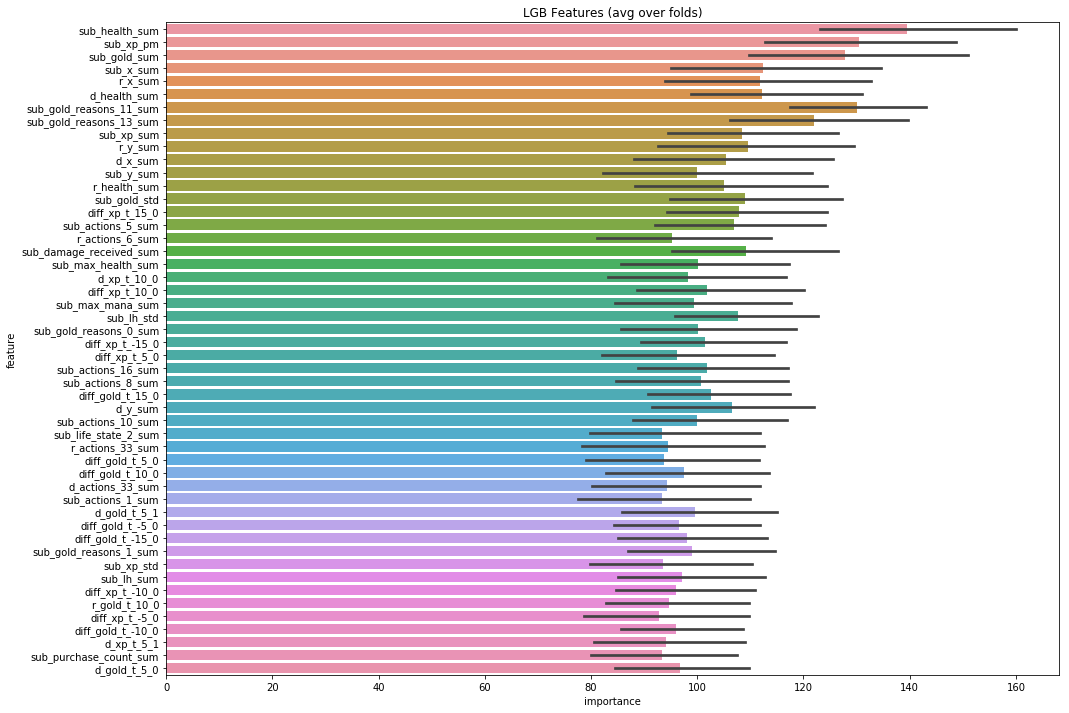

In [25]:
y = target.radiant_win.values

oof_lgb, prediction, scores = train_model(team_train.reset_index(drop=True), team_test.reset_index(drop=True),
                                          y, params=params, folds=folds, plot_feature_importance=True)

In [26]:
def train_model_plus(X, X_test, y, params, folds, score_func=roc_auc_score, cat_feat=''):
    oof = np.zeros(len(X))
    scores = []
    prediction = np.zeros(len(X_test))

    oof_preds = {'time_remaining': np.zeros(len(X)),
                 'next_roshan_team': np.zeros(len(X)),
                 'radiant_win': np.zeros(len(X))}

    for col in ['time_remaining', 'next_roshan_team']:
        print(col)
        for fold_n, (train_index, valid_index) in enumerate(folds[col].split(X, y['radiant_win'])):
            print('Fold', fold_n, 'started at', time.ctime())
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[col][train_index], y[col][valid_index]

            if col == 'next_roshan_team':
                train_data = lgb.Dataset(X_train[y_train > 0], label=y_train[y_train > 0] - 1)
            else:
                train_data = lgb.Dataset(X_train, label=y_train)

            model = lgb.train(params[col], train_data, num_boost_round=4500, categorical_feature=cat_feat)

            y_pred_valid = model.predict(X_valid)
            oof_preds[col][valid_index] = y_pred_valid.reshape(-1,)

    col = 'radiant_win'
    print(col)
    X_conc = np.concatenate([X, oof_preds['time_remaining'].reshape(-1, 1), oof_preds['next_roshan_team'].reshape(-1, 1)], axis=1)
    for fold_n, (train_index, valid_index) in enumerate(folds[col].split(X, y['radiant_win'])):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X_conc[train_index], X_conc[valid_index]
        y_train, y_valid = y[col][train_index], y[col][valid_index]
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid)

        model = lgb.train(params[col], train_data, num_boost_round=20000, valid_sets=[valid_data],
                          verbose_eval=1000, early_stopping_rounds=300, categorical_feature=cat_feat)

        y_pred_valid = model.predict(X_valid)
        oof_preds[col][valid_index] = y_pred_valid.reshape(-1,)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        prediction += y_pred
        scores.append(score_func(y_valid, y_pred_valid))

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    prediction /= n_fold

    return oof_preds['radiant_win'], prediction, scores

In [27]:
y = {'time_remaining':   np.sqrt(target.time_remaining.values),
     'next_roshan_team': LabelEncoder().fit_transform(target.next_roshan_team.fillna('')),
     'radiant_win':      target.radiant_win.values}

params = {'time_remaining': {'boost': 'gbdt', 'feature_fraction': 0.05, 'learning_rate': 0.01, 'max_depth': -1, 'metric':'mse', 'min_data_in_leaf': 50, 
                             'num_leaves': 32,  'num_threads': -1, 'verbosity': 1, 'objective': 'regression', 'seed': 442},
         'next_roshan_team': {'boost': 'gbdt', 'feature_fraction': 0.05, 'learning_rate': 0.01, 'max_depth': -1, 'metric':'auc', 'min_data_in_leaf': 50, 
                             'num_leaves': 32,  'num_threads': -1, 'verbosity': 1, 'objective': 'binary', 'lambda_l1': 1.0, 'seed': 775},
         'radiant_win': {'boost': 'gbdt', 'feature_fraction': 0.05, 'learning_rate': 0.01, 'max_depth': -1, 'metric':'auc', 'min_data_in_leaf': 50, 
                             'num_leaves': 32,  'num_threads': -1, 'verbosity': 1, 'objective': 'binary', 'lambda_l1': 1.0, 'seed': 153}}

n_fold = 7
folds = {'time_remaining':   StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=71),
         'next_roshan_team': StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=12),
         'radiant_win':      StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)}

cols_model = [col for col in team_train.columns if col not in cols_to_drop]
oof_lgb_plus, prediction_plus, scores_plus = train_model_plus(team_train[cols_model].to_numpy(), team_test[cols_model].to_numpy(),
                                               y, params=params, folds=folds)

time_remaining
Fold 0 started at Wed Nov  6 19:41:00 2019
Fold 1 started at Wed Nov  6 19:42:19 2019
Fold 2 started at Wed Nov  6 19:43:37 2019
Fold 3 started at Wed Nov  6 19:44:55 2019
Fold 4 started at Wed Nov  6 19:46:14 2019
Fold 5 started at Wed Nov  6 19:47:33 2019
Fold 6 started at Wed Nov  6 19:48:53 2019
next_roshan_team
Fold 0 started at Wed Nov  6 19:50:11 2019
Fold 1 started at Wed Nov  6 19:51:12 2019
Fold 2 started at Wed Nov  6 19:52:15 2019
Fold 3 started at Wed Nov  6 19:53:17 2019
Fold 4 started at Wed Nov  6 19:54:20 2019
Fold 5 started at Wed Nov  6 19:55:21 2019
Fold 6 started at Wed Nov  6 19:56:24 2019
radiant_win
Fold 0 started at Wed Nov  6 19:57:27 2019
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's auc: 0.839313
[2000]	valid_0's auc: 0.846334
[3000]	valid_0's auc: 0.848193
[4000]	valid_0's auc: 0.848758
Early stopping, best iteration is:
[4285]	valid_0's auc: 0.848901
Fold 1 started at Wed Nov  6 19:59:00 2019
Training until v

In [28]:
def train_model_stacking(X, X_test, y, params, folds, score_func=roc_auc_score, cat_feat='', target_col='radiant_win'):
    oof = np.zeros(len(X))
    scores = []
    prediction = np.zeros(len(X_test))
    models = dict()
    oof_preds = {'time_remaining': np.zeros(len(X)),
                 'next_roshan_team': np.zeros(len(X)),
                 'radiant_win': np.zeros(len(X))}
    oof_pred = np.zeros(len(X))

    for col in ['time_remaining', 'next_roshan_team', 'radiant_win']:
        print(col)
        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y[target_col])):
            print('Fold', fold_n, 'started at', time.ctime())
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[col][train_index], y[col][valid_index]

            if col == 'next_roshan_team':
                train_data = lgb.Dataset(X_train[y_train > 0], label=y_train[y_train > 0] - 1)
            else:
                train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            models[col] = lgb.train(params[col], train_data, num_boost_round=20000, valid_sets=[valid_data],
                          verbose_eval=1000, early_stopping_rounds=300, categorical_feature=cat_feat)

            y_pred_valid = models[col].predict(X_valid)
            oof_preds[col][valid_index] = y_pred_valid.reshape(-1,)

    col = 'stacking'
    oof_preds = np.concatenate([preds.reshape(-1, 1) for preds in oof_preds.values()], axis=1)
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y[target_col])):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = oof_preds[train_index], oof_preds[valid_index]
        y_train, y_valid = y[target_col][train_index], y[target_col][valid_index]
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid)

        models[col] = lgb.train(params[col], train_data, num_boost_round=20000, valid_sets=[valid_data],
                      verbose_eval=1000, early_stopping_rounds=300, categorical_feature=cat_feat)

        y_pred_valid = models[col].predict(X_valid)
        oof_pred[valid_index] = y_pred_valid.reshape(-1,)
        
        y_pred = models[col].predict(X_test, num_iteration=models[col].best_iteration)
        prediction += y_pred
        scores.append(score_func(y_valid, y_pred_valid))

    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    prediction /= n_fold

    return oof_pred, prediction, scores

In [29]:
y = {'time_remaining':   np.sqrt(target.time_remaining.values),
     'next_roshan_team': LabelEncoder().fit_transform(target.next_roshan_team.fillna('')),
     'radiant_win':      target.radiant_win.values}

params = {'time_remaining': {'boost': 'gbdt', 'feature_fraction': 0.05, 'learning_rate': 0.01, 'max_depth': -1, 'metric':'mse', 'min_data_in_leaf': 50, 
                             'num_leaves': 32,  'num_threads': -1, 'verbosity': 1, 'objective': 'regression', 'seed': 442},
         'next_roshan_team': {'boost': 'gbdt', 'feature_fraction': 0.05, 'learning_rate': 0.01, 'max_depth': -1, 'metric':'auc', 'min_data_in_leaf': 50, 
                             'num_leaves': 32,  'num_threads': -1, 'verbosity': 1, 'objective': 'binary', 'lambda_l1': 1.0, 'seed': 775},
         'radiant_win': {'boost': 'gbdt', 'feature_fraction': 0.05, 'learning_rate': 0.01, 'max_depth': -1, 'metric':'auc', 'min_data_in_leaf': 50, 
                             'num_leaves': 32,  'num_threads': -1, 'verbosity': 1, 'objective': 'binary', 'lambda_l1': 1.0, 'seed': 153},
         'stacking': {'boost': 'gbdt', 'max_depth': 2, 'metric':'auc', 'num_threads': -1, 'verbosity': 1, 'objective': 'binary', 'seed': 153}}

n_fold = 7
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

cols_model = [col for col in team_train.columns if col not in cols_to_drop]
oof_lgb_stacking, prediction_stacking, scores_stacking = train_model_stacking(team_train[cols_model].to_numpy(), team_test[cols_model].to_numpy(),
                                               y, params=params, folds=folds)

time_remaining
Fold 0 started at Wed Nov  6 20:08:20 2019
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's l2: 49.0655
[2000]	valid_0's l2: 48.0304
[3000]	valid_0's l2: 47.6606
[4000]	valid_0's l2: 47.5626
[5000]	valid_0's l2: 47.556
Early stopping, best iteration is:
[4752]	valid_0's l2: 47.5359
Fold 1 started at Wed Nov  6 20:09:47 2019
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's l2: 45.5819
[2000]	valid_0's l2: 44.6984
[3000]	valid_0's l2: 44.4515
[4000]	valid_0's l2: 44.3647
[5000]	valid_0's l2: 44.3387
Early stopping, best iteration is:
[5089]	valid_0's l2: 44.3279
Fold 2 started at Wed Nov  6 20:11:22 2019
Training until validation scores don't improve for 300 rounds
[1000]	valid_0's l2: 49.8646
[2000]	valid_0's l2: 48.8461
[3000]	valid_0's l2: 48.5212
[4000]	valid_0's l2: 48.4108
Early stopping, best iteration is:
[4475]	valid_0's l2: 48.3667
Fold 3 started at Wed Nov  6 20:12:50 2019
Training until validation scor

In [30]:
sub = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
sub['radiant_win_prob'] = prediction
sub.to_csv('submission.csv', index=False)
sub.head()

,match_id_hash,radiant_win_prob
0,30cc2d778dca82f2edb568ce9b585caa,0.278316
1,70e5ba30f367cea48793b9003fab9d38,0.995695
2,4d9ef74d3a2025d79e9423105fd73d41,0.976307
3,2bb79e0c1eaac1608e5a09c8e0c6a555,0.786174
4,bec17f099b01d67edc82dfb5ce735a43,0.239084


In [31]:
sub = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
sub['radiant_win_prob'] = prediction_plus
sub.to_csv('submission_prediction_plus.csv', index=False)
sub.head()

,match_id_hash,radiant_win_prob
0,30cc2d778dca82f2edb568ce9b585caa,0.203463
1,70e5ba30f367cea48793b9003fab9d38,0.990749
2,4d9ef74d3a2025d79e9423105fd73d41,0.946756
3,2bb79e0c1eaac1608e5a09c8e0c6a555,0.666099
4,bec17f099b01d67edc82dfb5ce735a43,0.147592


In [32]:
sub = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'))
sub['radiant_win_prob'] = prediction_stacking
sub.to_csv('submission_prediction_stacking.csv', index=False)
sub.head()

,match_id_hash,radiant_win_prob
0,30cc2d778dca82f2edb568ce9b585caa,0.008190
1,70e5ba30f367cea48793b9003fab9d38,0.992441
2,4d9ef74d3a2025d79e9423105fd73d41,0.008190
3,2bb79e0c1eaac1608e5a09c8e0c6a555,0.008190
4,bec17f099b01d67edc82dfb5ce735a43,0.008190


## Permutation importance

In [33]:
# from eli5.permutation_importance import get_score_importances

# def score(X, y):
#     y_pred = lgbmodel.predict(X)
#     return roc_auc_score(y, y_pred)

# y = target.radiant_win.values
# X = lgb.Dataset(team_train, label=y)
# train_data = lgb.Dataset(team_train, label=y)

# lgbmodel = lgb.train(params, train_data, num_boost_round=4500)

# base_score, score_decreases = get_score_importances(score, team_train.to_numpy(), y, n_iter=1)

In [34]:
# feature_importances = np.mean(score_decreases, axis=0)
# threshold = 0.001
# bad_features = team_train.columns[score_decreases[0] > -threshold]

In [35]:
# n_fold = 7
# folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [36]:
# from eli5.permutation_importance import get_score_importances

# def score(X, y):
#     y_pred = lgbmodel.predict(X)
#     return roc_auc_score(y, y_pred)

# y = target.radiant_win.to_numpy()
# X = team_train.to_numpy()

# best_scores = list()
# scores_dec = list()

# for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
#     print('Fold', fold_n, 'started at', time.ctime())
#     X_train, X_valid = X[train_index], X[valid_index]
#     y_train, y_valid = y[train_index], y[valid_index]

#     train_data = lgb.Dataset(X_train, label=y_train)
#     valid_data = lgb.Dataset(X_valid, label=y_valid)

#     lgbmodel = lgb.train(params, train_data, num_boost_round=4500)

#     base_score, score_decreases = get_score_importances(score, X_valid, y_valid, n_iter=1)

#     best_scores.append(base_score)
#     scores_dec.append(score_decreases)

In [37]:
# import pickle

# with open('scores_dec.pickle', 'wb') as f:
#     pickle.dump((best_scores, scores_dec), f)

In [38]:
# from sklearn.metrics import mean_squared_error, mean_absolute_error

# params = {'boost': 'gbdt',
#           'feature_fraction': 0.05,
#           'learning_rate': 0.01,
#           'max_depth': -1,  
#           'metric':'mae',
#           'min_data_in_leaf': 50,
#           'num_leaves': 32,
#           'num_threads': -1,
#           'verbosity': 1,
#           'objective': 'regression_l1'
#          }

# # y = target.time_remaining.values
# y = np.sqrt(target.time_remaining.values)

# n_fold = 7
# reg_folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

# oof_lgb, prediction, scores = train_model(team_train.reset_index(drop=True), team_test.reset_index(drop=True),
#                                           y, params=params, folds=reg_folds, plot_feature_importance=True, score_func=mean_absolute_error)

In [39]:
# plt.scatter(np.power(y, 2), np.power(oof_lgb, 2), s=1);
# plt.title('MAE');

In [40]:
# plt.scatter(np.power(y, 2), np.power(oof_lgb, 2), s=1);
# plt.title('MSE');

In [41]:
# def train_model(X, X_test, y, params, folds, plot_feature_importance=False, averaging='usual', model=None, cat_feat='', score_func=roc_auc_score):
#     oof = np.zeros(len(X))
#     prediction = np.zeros((len(X_test), 3))
#     scores = []
#     feature_importance = pd.DataFrame()
    
#     for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
#         print('Fold', fold_n, 'started at', time.ctime())
#         X_train, X_valid = X.loc[train_index], X.loc[valid_index]
#         y_train, y_valid = y[train_index], y[valid_index]

#         train_data = lgb.Dataset(X_train, label=y_train)
#         valid_data = lgb.Dataset(X_valid, label=y_valid)
            
#         model = lgb.train(params,
#                 train_data,
#                 num_boost_round=20000,
#                 valid_sets = [valid_data],
#                 verbose_eval=1000,
#                 early_stopping_rounds = 300,
#                 categorical_feature=cat_feat)

#         y_pred_valid = model.predict(X_valid)
#         y_pred = model.predict(X_test, num_iteration=model.best_iteration)
#         prediction += y_pred
  
#         oof[valid_index] = np.argmax(y_pred_valid, axis=1).reshape(-1,)
#         scores.append(score_func(y_valid, y_pred_valid))

#         # feature importance
#         fold_importance = pd.DataFrame()
#         fold_importance["feature"] = X.columns
#         fold_importance["importance"] = model.feature_importance()
#         fold_importance["fold"] = fold_n + 1
#         feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

#     print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
#     prediction /= n_fold
#     feature_importance["importance"] /= n_fold
#     if plot_feature_importance:
#         cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
#             by="importance", ascending=False)[:50].index

#         best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

#         plt.figure(figsize=(16, 12));
#         sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
#         plt.title('LGB Features (avg over folds)');

#         return oof, prediction, feature_importance
#     return oof, prediction, scores

In [42]:
# from sklearn.metrics import log_loss
# from sklearn.preprocessing import LabelEncoder

# params = {'boost': 'gbdt',
#           'feature_fraction': 0.05,
#           'learning_rate': 0.01,
#           'max_depth': -1,  
#           'min_data_in_leaf': 50,
#           'num_leaves': 32,
#           'num_threads': -1,
#           'verbosity': 1,
#           'objective': 'multiclass',
#           "num_class" : 3
#          }

# y = LabelEncoder().fit_transform(target.next_roshan_team.fillna(''))
# # y = pd.get_dummies(target.next_roshan_team.fillna(''), prefix='t')

# oof_lgb, prediction, scores = train_model(team_train.reset_index(drop=True), team_test.reset_index(drop=True),
#                                           y, params=params, folds=folds, plot_feature_importance=True, score_func=log_loss)

In [43]:
# from sklearn.metrics import log_loss, roc_auc_score
# from sklearn.preprocessing import LabelEncoder

# params = {'boost': 'gbdt',
#           'feature_fraction': 0.05,
#           'learning_rate': 0.01,
#           'max_depth': -1,  
#           'metric':'auc',
#           'min_data_in_leaf': 50,
#           'num_leaves': 32,
#           'num_threads': -1,
#           'verbosity': 1,
#           'objective': 'binary',
#           'lambda_l1': 1.0
#          }

# y = LabelEncoder().fit_transform(target.next_roshan_team.fillna(''))
# # y = pd.get_dummies(target.next_roshan_team.fillna(''), prefix='t')

# oof_lgb, prediction, scores = train_model(team_train.loc[y > 0].reset_index(drop=True), team_test.reset_index(drop=True),
#                                           y[y > 0] - 1, params=params, folds=folds, plot_feature_importance=True, score_func=roc_auc_score)

In [44]:
# oht = OneHotEncoder(sparse=False)
# oht.fit(y.reshape(-1, 1))
# log_loss(oht.transform(y.reshape(-1, 1)),oht.transform(oof_lgb.reshape(-1, 1)))

In [45]:
# np.mean(y == oof_lgb)

In [46]:
# pd.get_dummies(target.next_roshan_team.fillna(''), prefix='t')